# Hateful memes baseline
This notebook aims to establish a baseline we will be using for experiments. It will contain the following unimodally pretained components:
- BERT for text classification
- CLIP for visual embeddings

For the classification head, it will use default head of BERTforSequenceClassication, which comprises of two linear layers.


## Step 0: Loading the data and importing libraries

### Loading libraries


In [33]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
import pandas as pd    
import os

In [7]:
#install transformer if not there
#!pip install transformers
#!pip install opencv-python
#!pip install pandas

  Using cached pandas-1.4.2-cp39-cp39-macosx_10_9_x86_64.whl (11.1 MB)
  Using cached pytz-2022.1-py2.py3-none-any.whl (503 kB)


In [34]:
from torch.utils.data import DataLoader
from transformers import AdamW

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm

### Loading Data

Next we need to connect to the storage. The script assumes the following folder structure:
```
.
|-hateful_memes
  |-dev_seen.jsonl
  |-train_jsonl
  |-img
    |-{all memes}
  [-embeds
    |-{all embeds}
```

So basically just make sure you have the unzipped hateful memes folder in the current working directory. Feel free to change this part to something that works with your environment

The data is available on my google drive for those who want to download the embedding directly or look at folder structure:

https://drive.google.com/drive/folders/19KGR-NA-XzdDaAlHcKcwCqatDxpS4W5s?usp=sharing

If the embeddings are downloaded, after finishing step 0 you can skip directly to step 3

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [5]:
#navigate to correct folder
%cd 'gdrive/MyDrive/OMSCS/CS7643/Project'
!ls

/content/gdrive/MyDrive/OMSCS/CS7643/Project
embeds	hateful_memes  hateful_memes.zip


In [36]:
train = pd.read_json(path_or_buf="hateful_memes/train.jsonl", lines=True)
val = pd.read_json(path_or_buf="hateful_memes/dev_seen.jsonl", lines=True)
test = pd.read_json(path_or_buf="hateful_memes/test_seen.jsonl", lines=True)



In [37]:
# visualing the train set
train

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...


meme_text1: its their character not their color that matters
meme_label1: 0
(400, 265, 3)


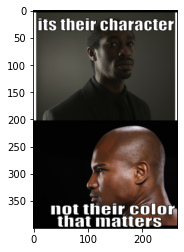

In [38]:
#visualizing the image
idx = 0
meme_text1 = train['text'][idx]
meme_label1 = train['label'][idx]
img1 = plt.imread(f"hateful_memes/{train['img'][idx]}")
print(f"meme_text1: {meme_text1}")
print(f"meme_label1: {meme_label1}")
print(img1.shape)
plt.imshow(img1)

### Creating Torch DataSet Class

In [39]:
from torch.utils.data import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, BertModel
from transformers import CLIPFeatureExtractor, CLIPVisionModel
from transformers import Trainer, TrainingArguments
from PIL import Image


#creating a pytorch dataset format
class HMdataset(Dataset):
    def __init__(self,dataframe, tokenizer, img_tfm = None, text_only = False):
    #tokenized representation of text
        self.text = dataframe['text']
        self.text_tokens = tokenizer(dataframe['text'].to_list(),padding = True)
        self.labels = torch.tensor(dataframe['label'])
        self.img = dataframe['img']
        self.img_tfm = img_tfm
        self.text_only = text_only

    def __getitem__(self,idx):
        item = {}
        item['text'] = self.text[idx]
        item['text_tokens'] = torch.tensor(self.text_tokens['input_ids'][idx])
        item['attention_mask'] = torch.tensor(self.text_tokens['attention_mask'][idx])
        item['labels'] = self.labels[idx]
        if not self.text_only:
            item['img'] = self.img_tfm(Image.open(f"hateful_memes/{self.img[idx]}").convert('RGB'))

        return item
    def __len__(self):
        return len(self.labels)

In [40]:
#creating tokens
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
#converting image to same size
clip_ftm = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')
img_tfm = lambda im: clip_ftm(images=im, return_tensors='pt', do_center_crop=False)['pixel_values'][0]

# #creating dataset with these encodings and img transformation
train_dataset = HMdataset(train, tokenizer,img_tfm)
val_dataset = HMdataset(val, tokenizer,img_tfm)
test_dataset = HMdataset(test, tokenizer,img_tfm)

In [41]:
# creating dataloader
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= False)

#sanity checks
item = next(iter(train_dataloader))

display(item['img'][0].shape)
display(item['text'][0])
display(item['text_tokens'][0])
display(item['attention_mask'][0])

torch.Size([3, 224, 224])

'its their character not their color that matters'

tensor([ 101, 2049, 2037, 2839, 2025, 2037, 3609, 2008, 5609,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


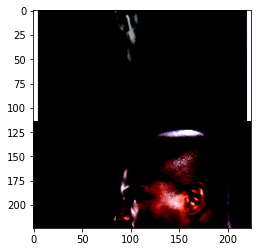

In [42]:
plt.imshow(item['img'][0].transpose(0,2).transpose(0,1))

## Step 1: Creating text embeddings

In [13]:
#will use the dataset but with text only set to True, this will speed up read/write since we are only dealing with text at the time
train_dataset = HMdataset(train, tokenizer,img_tfm, text_only = True)
val_dataset = HMdataset(val, tokenizer,img_tfm, text_only = True)
test_dataset = HMdataset(test, tokenizer,img_tfm, text_only = True)

IMPORTANT: Choose the intended model here:

In [14]:
#create model for training
text_model_name = "bert-base-uncased"
text_embed_model = BertModel.from_pretrained(text_model_name)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# create embeddings
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

text_embed_model.to(device)

#have data loaders ready
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

#function to generate embeddings given a model and a data loader. Also returns label incase shuffle is set to true
def generate_text_embeddings(loader, embed_model):
  embed = []
  with torch.no_grad():
      progress_bar = tqdm_notebook(loader, unit = 'batch')
      batch_no = 1
      for batch in progress_bar:
        
        input_ids = batch['text_tokens'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = embed_model(input_ids, attention_mask = attention_mask, output_hidden_states = True)

        #populate embeddings and move them back to cpu
        embed.append(outputs['last_hidden_state'].to(torch.device('cpu')))

        #upadate progress bar
        progress_bar.set_description_str(f"Batch: {batch_no}")
        batch_no +=1

        #emtpy catche
        torch.cuda.empty_cache()

        
  
  #concatenate data across all batches
  embeds = torch.cat(embed,dim = 0)

  return embeds




In [16]:
# see if embeddings are saved, otherwise generate embeddings


if os.path.exists(f"embeds/{text_model_name}_train_embeds.pt"):
  print("embedding already exists")
else:
  print("generating embeddings")
  train_text_embeds = generate_text_embeddings(train_loader, text_embed_model)
  val_text_embeds = generate_text_embeddings(val_loader, text_embed_model)
  test_text_embeds = generate_text_embeddings(test_loader, text_embed_model)

  #sanity checks
  display(train_text_embeds.shape) #see shape of (dataset length, sequence_length, dimension)
  display(val_text_embeds.shape) #see shape of (dataset length, sequence_length, dimension)
  display(test_text_embeds.shape) #see shape of (dataset length, sequence_length, dimension)

  #create embeds folder and then store to disk to save time
  try:
    import os
    os.mkdir("embeds")
  except:
    pass
  #store tensor to disk
  torch.save(train_text_embeds,f"embeds/{text_model_name}_train_embeds.pt")
  torch.save(val_text_embeds,f"embeds/{text_model_name}_val_embeds.pt")
  torch.save(test_text_embeds,f"embeds/{text_model_name}_test_embeds.pt")

  # delete embeddings to save ram
  del train_text_embeds
  del val_text_embeds
  del test_text_embeds


embedding already exists


## Step 2: Creating Visual Embeddings

In [43]:
vision_model = "ViT"
if vision_model == "clip":
  #imports for clip
    from transformers import CLIPVisionModel, CLIPFeatureExtractor

    #set and load pretrained models
    vision_model_name = 'openai/clip-vit-base-patch32'
    vision_embed_model = CLIPVisionModel.from_pretrained(vision_model_name)
    feature_extractor = CLIPFeatureExtractor.from_pretrained(vision_model_name)
elif vision_model == "Beit":
    #imports for Beit
    from transformers import BeitModel, BeitFeatureExtractor

    #set and load pretrained models
    vision_model_name = 'microsoft/beit-base-patch16-224'
    vision_embed_model = BeitModel.from_pretrained(vision_model_name)
    feature_extractor = BeitFeatureExtractor.from_pretrained(vision_model_name)
elif vision_model == "ViT":
    from transformers import ViTFeatureExtractor, ViTModel

    #set and load pretrained models
    vision_model_name = 'google/vit-base-patch16-224-in21k'
    vision_embed_model = ViTModel.from_pretrained(vision_model_name)
    feature_extractor = ViTFeatureExtractor.from_pretrained(vision_model_name)

else:
    raise Exception("Invalid model chosen")

img_tfm = lambda im: feature_extractor(images=im, return_tensors='pt', do_center_crop=False)['pixel_values'][0]



Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [44]:

#will use the dataset wuth the images
train_dataset = HMdataset(train, tokenizer, img_tfm,text_only = False)
val_dataset = HMdataset(val, tokenizer, img_tfm, text_only = False)
test_dataset = HMdataset(test, tokenizer, img_tfm, text_only = False)



In [45]:
# create embeddings
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



#have data loaders ready
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

#function to generate embeddings given a model and a data loader. Also returns label incase shuffle is set to true
# returns:
# 1) embeds: embedding from the last hidden layer
# 2) labels: labels for each embedding of 0 or 1
# 3) hidden states: list of hidden states. -1 is the last hidden layer

def generate_vision_embeddings(loader, vision_embed_model):
    print(f"generating embeddings for {vision_model_name}")
    embed = []
    vision_embed_model.to(device)

    with torch.no_grad():
        #create progress bar
        progress_bar = tqdm_notebook(loader, unit = 'batch')
        batch_no = 1

        #run batchwise embedding generation
        for batch in progress_bar:
            imgs = batch['img'].to(device)
            labels = batch['labels'].to(device)


            outputs = vision_embed_model(imgs, output_hidden_states = True)

            #populate embeddings
            embed.append(outputs['last_hidden_state'].to(torch.device('cpu')))

            #upadate progress bar
            progress_bar.set_description_str(f"Batch: {batch_no}")
            batch_no +=1

            #emtpy catche
            torch.cuda.empty_cache()
    
    embeds = torch.cat(embed,dim = 0)

    return embeds


In [46]:

if vision_model == "clip":
    vision_model_save_name = "clip-vit-base-patch32"
elif vision_model == "Beit":
    vision_model_save_name = "beit-base-patch16-224"
elif vision_model == "ViT":
    vision_model_save_name = "vit-base-patch16-224-in21k"


if os.path.exists(f"embeds/{vision_model_save_name}_train_embeds.pt"):
    print("embedding already exists")
else:
    print("generating embeddings")
    train_vision_embeds = generate_vision_embeddings(train_loader,vision_embed_model)
    val_vision_embeds = generate_vision_embeddings(val_loader,vision_embed_model)
    test_vision_embeds = generate_vision_embeddings(test_loader,vision_embed_model)

    #show dimension
    print(f"Shape of training embeds: {train_vision_embeds.shape}") # shape of size (set size, sequence_len, dimension)

    #store tensor to disk
    torch.save(train_vision_embeds,f"embeds/{vision_model_save_name}_train_embeds.pt")
    torch.save(val_vision_embeds,f"embeds/{vision_model_save_name}_val_embeds.pt")
    torch.save(test_vision_embeds,f"embeds/{vision_model_save_name}_test_embeds.pt")
  

generating embeddings
generating embeddings for google/vit-base-patch16-224-in21k


/var/folders/26/n4j01dbx3lg_bh5dc_qygyg80000gp/T/ipykernel_70629/1844297765.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(loader, unit = 'batch')


  0%|          | 0/133 [00:00<?, ?batch/s]

generating embeddings for google/vit-base-patch16-224-in21k


  0%|          | 0/8 [00:00<?, ?batch/s]

generating embeddings for google/vit-base-patch16-224-in21k


  0%|          | 0/16 [00:00<?, ?batch/s]

Shape of training embeds: torch.Size([8500, 197, 768])


In [31]:
#store tensor to disk
torch.save(train_vision_embeds,f"embeds/{vision_model_save_name}_train_embeds.pt")
torch.save(val_vision_embeds,f"embeds/{vision_model_save_name}_val_embeds.pt")
torch.save(test_vision_embeds,f"embeds/{vision_model_save_name}_test_embeds.pt")

In [32]:
del train_vision_embeds
del val_vision_embeds
del test_vision_embeds

In [ ]:
train_vision_embeds = generate_vision_embeddings(train_loader,vision_embed_model)
val_vision_embeds = generate_vision_embeddings(val_loader,vision_embed_model)
test_vision_embeds = generate_vision_embeddings(test_loader,vision_embed_model)

#show dimension
train_vision_embeds.shape # shape of size (set size, sequence_len, dimension)

#store tensor to disk
torch.save(train_vision_embeds,f"embeds/{vision_model_save_name}_train_embeds.pt")
torch.save(val_vision_embeds,f"embeds/{vision_model_save_name}_val_embeds.pt")
torch.save(test_vision_embeds,f"embeds/{vision_model_save_name}_test_embeds.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/133 [00:00<?, ?batch/s]

In [ ]:
val_vision_embeds.shape

## Step 3: Running Classification

### Reading Saved Embeddings
First we will read in the saved embeddings



In [74]:
#choose embeddings to load

vision_model_save_name = "beit-base-patch16-224"
#vision_model_save_name = "clip-vit-base-patch32"
text_model_name = "bert-base-uncased"


#reading text embeds
train_text_embeds = torch.load(f"embeds/{text_model_name}_train_embeds.pt")
val_text_embeds = torch.load(f"embeds/{text_model_name}_val_embeds.pt")
test_text_embeds = torch.load(f"embeds/{text_model_name}_test_embeds.pt")

#reading vision embeds
train_vision_embeds = torch.load(f"embeds/{vision_model_save_name}_train_embeds.pt")
val_vision_embeds = torch.load(f"embeds/{vision_model_save_name}_val_embeds.pt")
test_vision_embeds = torch.load(f"embeds/{vision_model_save_name}_test_embeds.pt")



In [75]:
#creating a dataset of just embeds in pytorch dataset format
class HMEmbedsdataset(Dataset):
  def __init__(self,visual_embeddings, text_embeddings,labels):
    self.text_embeddings = text_embeddings
    self.visual_embeddings = visual_embeddings
    self.labels = torch.tensor(labels, dtype = torch.float32)

  def __getitem__(self,idx):
    item = {'text_embeds' : self.text_embeddings[idx],'visual_embeds': self.visual_embeddings[idx],'labels':self.labels[idx]}
    return item

  def __len__(self):
    return len(self.labels)

In [76]:
#create new dataset which contains just embeddings that were calculated previously
train_embeds  = HMEmbedsdataset(train_vision_embeds, train_text_embeds, train['label'].to_list())
val_embeds  = HMEmbedsdataset(val_vision_embeds, val_text_embeds,val['label'].to_list())
test_embeds  = HMEmbedsdataset(test_vision_embeds, test_text_embeds,test['label'].to_list())

### Creating the Base Classifier
The implementation was followed from the DistilBERTforSequenceClassification head available [here](https://github.com/huggingface/transformers/blob/e6f00a11d7fa34215184e3c797e19e6c7debe0fe/src/transformers/models/distilbert/modeling_distilbert.py#L687-L788)

The BERT classification head was also very similar, and is available [here](https://github.com/huggingface/transformers/blob/e6f00a11d7fa34215184e3c797e19e6c7debe0fe/src/transformers/models/bert/modeling_bert.py#L1503-L1597) if you want to compare.

In [77]:
# Base classifier based on sequence classification head from BERT
class BaseClassifier(nn.Module):
    def __init__(self, n_embeds, dp=0.25, n_out=1):
        super().__init__()
        self.n_embeds = n_embeds

        self.pre_classifier = nn.Linear(n_embeds, n_embeds)
        self.classifier = nn.Linear(n_embeds, 1)
        self.dropout = nn.Dropout(dp)

    def forward(self, vis_features, lang_features):
        comb_output = torch.concat([vis_features[:,0,:], lang_features[:,0,:]], axis=1) # keep only first token from both
        pooled_output = self.pre_classifier(comb_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)
        logits = F.sigmoid(logits)
        return logits


In [78]:
#get dimension by concatenating features
n_embeds = train_text_embeds.shape[-1]+ train_vision_embeds.shape[-1]
n_embeds

1536

In [79]:
# Create Dataloaders for classification
BATCH_SIZE = 64
train_embed_loader = DataLoader(train_embeds, batch_size = BATCH_SIZE, shuffle = True)
val_embed_loader = DataLoader(val_embeds, batch_size = BATCH_SIZE, shuffle = True)
test_embed_loader = DataLoader(test_embeds, batch_size = BATCH_SIZE, shuffle = True)

### Running training
Finally, we will run training, while calculating the validation and test accuracy

In [80]:
from sklearn.metrics import roc_auc_score

# running classification on this embedding dataset
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BaseClassifier(n_embeds)

#send embed model to device
model.to(device)

model.train()

optimizer = AdamW(model.parameters(), lr = 1e-5)
# criteria = nn.MSELoss()
criteria = nn.BCELoss()
criteria.to(device)

num_epochs = 100
for epoch in range(num_epochs):
  print("-----------------------------------")
  print("Epoch %d" % (epoch+1))
  print("-----------------------------------")
  progress_bar = tqdm_notebook(train_embed_loader, unit = 'batch')
  batch_no = 0

  #run training for epoch
  for batch in progress_bar:
    
    batch_no+=1

    optimizer.zero_grad()

    #send things to device
    text_embeds = batch['text_embeds'].to(device)
    vis_embeds = batch['visual_embeds'].to(device)
    labels = batch['labels'].to(device)

    #run classification
    outputs = model(vis_embeds, text_embeds).squeeze(dim = 1)
    pred = outputs

    loss = criteria(pred, labels)
    loss.backward()
    optimizer.step()

    progress_bar.set_description_str(f"Batch: {batch_no}, loss = {loss.item()}")
  
  #get validation loss and accuracy
  preds = []
  y_true = []
  with torch.no_grad():
    for batch in val_embed_loader:
      
      text_embeds = batch['text_embeds'].to(device)
      vis_embeds = batch['visual_embeds'].to(device)
      labels = batch['labels'].to(device)
      y_true.append(labels)

      outputs = model(vis_embeds, text_embeds).squeeze(dim = 1)
      
      #get predictions
      pred = outputs
      preds.append(pred)

      loss = criteria(pred, labels)

      #accuracy = torch.sum(labels == (pred>0.5)).item()/len(pred)
      #accuracies.append(accuracy)
    preds = torch.cat(preds, dim = 0)
    y_true = torch.cat(y_true,dim = 0)

    # get scores
    accuracy = torch.sum(y_true == (preds>0.5)).item()/len(preds)
    roc_auc = roc_auc_score(y_true.cpu(), preds.cpu())
    print(f"val las loss: {loss}")
    print(f"val accuracy: {accuracy}")
    print(f"val ROC_AUC: {roc_auc}")

    
    



-----------------------------------
Epoch 1
-----------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?batch/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ValueError: ignored

Get test accuracy

In [ ]:
#get test loss and accuracy
from sklearn.metrics import roc_auc_score

preds = []
y_true = []
total_loss = 0
with torch.no_grad():
  for batch in test_embed_loader:
    
    text_embeds = batch['text_embeds'].to(device)
    vis_embeds = batch['visual_embeds'].to(device)
    labels = batch['labels'].to(device)
    y_true.append(labels)

    outputs = model(vis_embeds, text_embeds).squeeze(dim = 1)
    
    #get predictions
    pred = outputs
    preds.append(pred)

    loss = criteria(pred, labels)
    total_loss += loss

    #accuracy = torch.sum(labels == (pred>0.5)).item()/len(pred)
    #accuracies.append(accuracy)
  preds = torch.cat(preds, dim = 0)
  y_true = torch.cat(y_true,dim = 0)

  # get scores
  avg_loss = total_loss/len(preds)
  accuracy = torch.sum(y_true == (preds>0.5)).item()/len(preds)
  roc_auc = roc_auc_score(y_true.cpu(), preds.cpu())
  print(f"test average loss: {avg_loss}")
  print(f"test accuracy: {accuracy}")
  print(f"test ROC_AUC: {roc_auc}")

    
    
    

test average loss: 0.011489511467516422
test accuracy: 0.51
test ROC_AUC: 0.6098479391756703


In [ ]:
roc_auc_score(y_true.cpu(), preds.cpu())

0.7359983993597439